Installing required libraries

In [1]:
pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp37-none-any.whl size=8424 sha256=63ea10aec00e7c21e5c210cd2020a279a917fdb1d0702e82efc82c870b6955ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq68mlun/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [2]:
pip install sm

Importing  Required Libraries

In [4]:
import bs4 as bs
import pickle
import requests
import bs4 as bs
import pickle
import numpy as np
import requests
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web 
import datetime as dt
import matplotlib.pyplot as plt
import sm
import statsmodels as sm

from matplotlib import style
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.tsa.api as smt
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Data-mining : we have scrapped the data from the wikipedia site which internally uses s&p data.

Scraping using beautiful soup from the html page.

In [ ]:
def extract_files():

 auth=requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
 bs_req = bs.BeautifulSoup(auth.text)
 html_table = bs_req.find('table',{'class':'wikitable sortable'})
 tickers=[]
 for i in html_table.findAll('tr')[1:]:
  ticker= i.findAll('td')[0].text[:-1]
  tickers.append(ticker)
 with open("tickers.pickle",'wb') as f:
    pickle.dump(tickers, f)
 return tickers
extract_files()

In [6]:
def extract_data():

 
 with open("tickers.pickle",'rb') as f:
   tickers=pickle.load(f)
 if not os.path.exists('stock_files'):
  os.makedirs('stock_files')
 count=30
 start_date= dt.datetime(2010,1,1)
 end_date =dt.datetime(2021,1,1)
 count=0
 for ticker in tickers:
  if count==30:
   break
  count=count+1
 
  try:
    ticker_df = web.DataReader(ticker, 'yahoo', start_date, end_date)
    ticker_df.to_csv('stock_files/{}.csv'.format(ticker))
  except:
    print("Error")
    continue
extract_data()

In [63]:
# Loading Amazon company csv file from the folder 
AMZN_df = pd.read_csv('stock_files/AMZN.csv', index_col=0, parse_dates=True)

In [64]:
AMZN_df.head()   #printing first five rows

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994
2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002
2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000
2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000
2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004


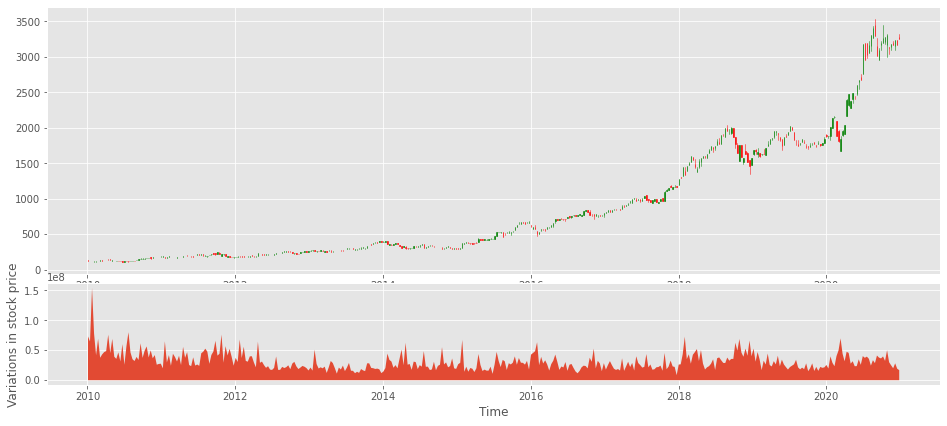

In [65]:
#  candle plot column adj close using ohlc and histogram of volume
ohlc_df = AMZN_df['Adj Close'].resample('10D').ohlc()
df_volume =AMZN_df['Volume'].resample('10D').sum()
plt.figure(figsize=(16,10))
ohlc_df.reset_index(inplace=True)
ohlc_df['Date']=ohlc_df['Date'].map(mdates.date2num)
candle_plot =plt.subplot2grid((10,1), (0,0), rowspan=5, colspan=2)
volume_plot =plt.subplot2grid((10,1), (5,0), rowspan=2, colspan=2 , sharex=candle_plot)
candle_plot.xaxis_date()
candlestick_ohlc(candle_plot,ohlc_df.values, width=2, colorup='g')
volume_plot.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Variations in stock price',fontsize=12)
plt.show()

In [66]:
# Adding column moving averages to the dataframe
AMZN_df['Moving_av'] = AMZN_df['Adj Close'].rolling(window=40,min_periods=0).mean()

In [67]:
# Adding two columns to the dataframe by performing mathematical operation using 
# volume and Adj close columns
k=1
increase_vol=[0]
increase_adj_close=[0]
while k<len(AMZN_df):
    increase_vol.append(AMZN_df.iloc[k]['Volume']-AMZN_df.iloc[k-1]['Volume'])
    increase_adj_close.append(AMZN_df.iloc[k]['Adj Close']-AMZN_df.iloc[k-1]['Adj Close'])
    k+=1

# Assigning into the dataframe columns    
AMZN_df['Increase_in_vol'] = increase_vol
AMZN_df['Increase_in_adj_close'] = increase_adj_close

##Exploratory data analysis

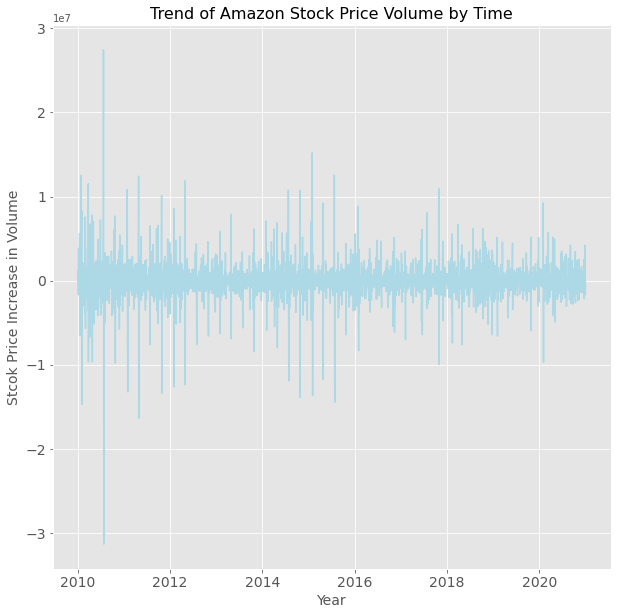

In [68]:
#plotting increase_in_vol columnn
plt.plot(AMZN_df['Increase_in_vol'], c='lightblue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Stcok Price Increase in Volume', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Trend of Amazon Stock Price Volume by Time', fontsize=16)
plt.show()

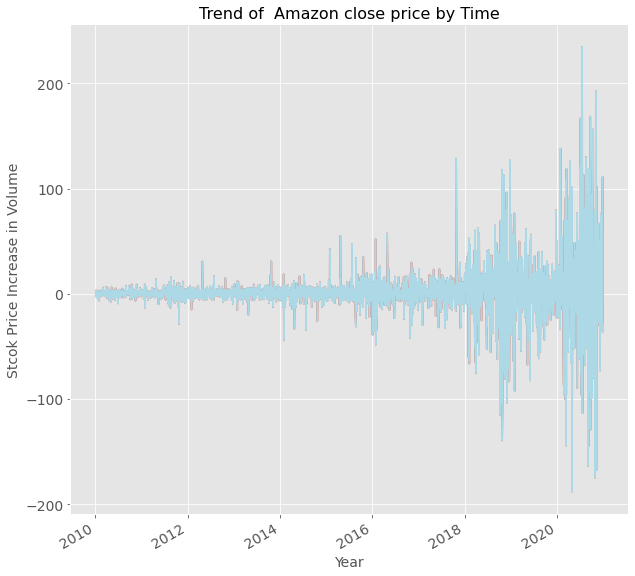

In [69]:
#plotting increase_in_adj_close columnn
AMZN_df['Increase_in_adj_close'].plot()
plt.plot(AMZN_df['Increase_in_adj_close'], c='lightblue')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Stcok Price Increase in Volume', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Trend of  Amazon close price by Time', fontsize=16)
plt.show()

In [70]:
# resetting index and adding index into column
AMZN_df.reset_index(inplace=True)
AMZN_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Moving_av,Increase_in_vol,Increase_in_adj_close
0,2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994,133.899994,0.0,0.000000
1,2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002,134.294998,1252000.0,0.790009
2,2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000,133.613332,-1673100.0,-2.440002
3,2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000,132.709999,3851400.0,-2.250000
4,2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004,132.872000,-1199700.0,3.520004


In [71]:
AMZN_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Moving_av,Increase_in_vol,Increase_in_adj_close
0,2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994,133.899994,0.0,0.000000
1,2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002,134.294998,1252000.0,0.790009
2,2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000,133.613332,-1673100.0,-2.440002
3,2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000,132.709999,3851400.0,-2.250000
4,2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004,132.872000,-1199700.0,3.520004


In [72]:
#Adding column year using date column 
AMZN_df['year'] = pd.DatetimeIndex(AMZN_df['Date']).year

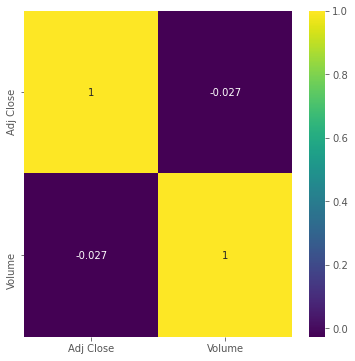

In [73]:
# correlation plot 
plt.figure(figsize=(6,6))
corr_plot = AMZN_df[['Adj Close', 'Volume']].corr()
sns.heatmap(corr_plot, annot = True, cmap='viridis')

In [74]:
# Changing Column name 
AMZN_df.rename(columns = {'Adj Close':'close'}, inplace = True)

In [75]:
AMZN_df

,Date,High,Low,Open,Close,Volume,close,Moving_av,Increase_in_vol,Increase_in_adj_close,year
0,2010-01-04,136.610001,133.139999,136.250000,133.899994,7599900,133.899994,133.899994,0.0,0.000000,2010
1,2010-01-05,135.479996,131.809998,133.429993,134.690002,8851900,134.690002,134.294998,1252000.0,0.790009,2010
2,2010-01-06,134.729996,131.649994,134.600006,132.250000,7178800,132.250000,133.613332,-1673100.0,-2.440002,2010
3,2010-01-07,132.320007,128.800003,132.009995,130.000000,11030200,130.000000,132.709999,3851400.0,-2.250000,2010
4,2010-01-08,133.679993,129.029999,130.559998,133.520004,9830500,133.520004,132.872000,-1199700.0,3.520004,2010
...,...,...,...,...,...,...,...,...,...,...,...
2764,2020-12-24,3202.000000,3169.000000,3193.899902,3172.689941,1451900,3172.689941,3157.126996,-641900.0,-12.580078,2020
2765,2020-12-28,3304.000000,3172.689941,3194.000000,3283.959961,5686800,3283.959961,3158.950745,4234900.0,111.270020,2020
2766,2020-12-29,3350.649902,3281.219971,3309.939941,3322.000000,4872900,3322.000000,3166.096997,-813900.0,38.040039,2020
2767,2020-12-30,3342.100098,3282.469971,3341.000000,3285.850098,3209300,3285.850098,3173.131250,-1663600.0,-36.149902,2020


In [76]:
#checking for the NULL values.
AMZN_df.isna().sum()

Date                     0
High                     0
Low                      0
Open                     0
Close                    0
Volume                   0
close                    0
Moving_av                0
Increase_in_vol          0
Increase_in_adj_close    0
year                     0
dtype: int64

In [77]:
# Computing IQR
Q1 = AMZN_df[["close","Volume"]].quantile(0.25)
Q3 = AMZN_df[["close","Volume"]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

close     1.256330e+03
Volume    2.529400e+06
dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


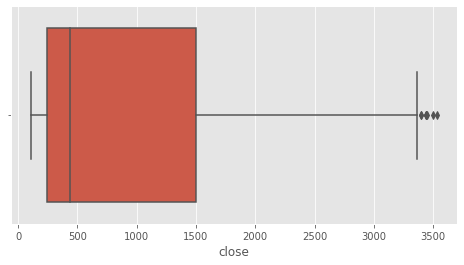

In [78]:
#Boxplot for the Stock price column
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
sns.boxplot("close", data=AMZN_df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


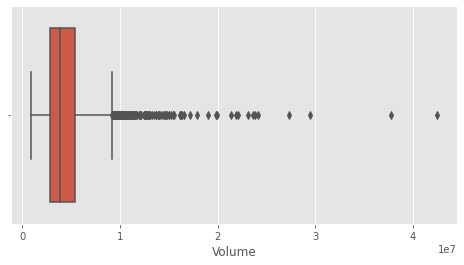

In [79]:
#Boxplot for the Stock volume column
plt.figure(figsize=(8,4))
sns.boxplot("Volume", data=AMZN_df)

In [80]:
len(AMZN_df[AMZN_df.Volume>Q3['Volume'] + 1.5*IQR[1]]) * 100/len(AMZN_df)

5.52546045503792

In [81]:
AMZN_df = AMZN_df[AMZN_df.Volume < AMZN_df.Volume.quantile(.95)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


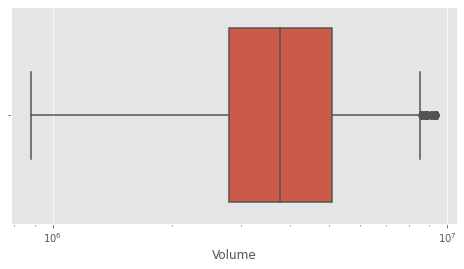

In [82]:
#box blot
plt.figure(figsize=(8,4))
sns.boxplot("Volume", data=AMZN_df)
plt.xscale("log")

In [83]:
len(AMZN_df[AMZN_df.Volume>Q3['Volume'] + 1.5*IQR[1]]) * 100/len(AMZN_df)

0.532319391634981

In [84]:
AMZN_df.drop(columns=['Date','year','Close'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [86]:
#assigning response variable and predictor value
X = AMZN_df.loc[:, AMZN_df.columns != 'close']
Y = AMZN_df[['close']]

In [87]:
#spliting the data into test and train data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=42, test_size=0.2)

In [88]:
print("Length Of training data ", len(X_train))
print("Length Of test data ", len(X_test))
print("Length Of training Y ", len(Y_train))
print("Length Of test data Y", len(Y_test))

Length Of training data  2104
Length Of test data  526
Length Of training Y  2104
Length Of test data Y 526


In [91]:
def linear_model(y_train, X_train, isSummary=False):
    """ function that formulates the linear regression model
    """
    #Constitute a Linear Regression Model
    
    # Add a bias column to the training dataset before fitting the model
    X_train = sm.tools.tools.add_constant(X_train, has_constant='add')
    reg_model = OLS(y_train,X_train).fit()
    
    if isSummary:
        #Visualise the results of the model
        print(reg_model.summary())
    return reg_model

In [92]:
model =   linear_model(Y_train, X_train, isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.170e+06
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:08:55   Log-Likelihood:                -6855.7
No. Observations:                2104   AIC:                         1.373e+04
Df Residuals:                    2096   BIC:                         1.377e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.73

#Hyperparameter tuning and final model selection

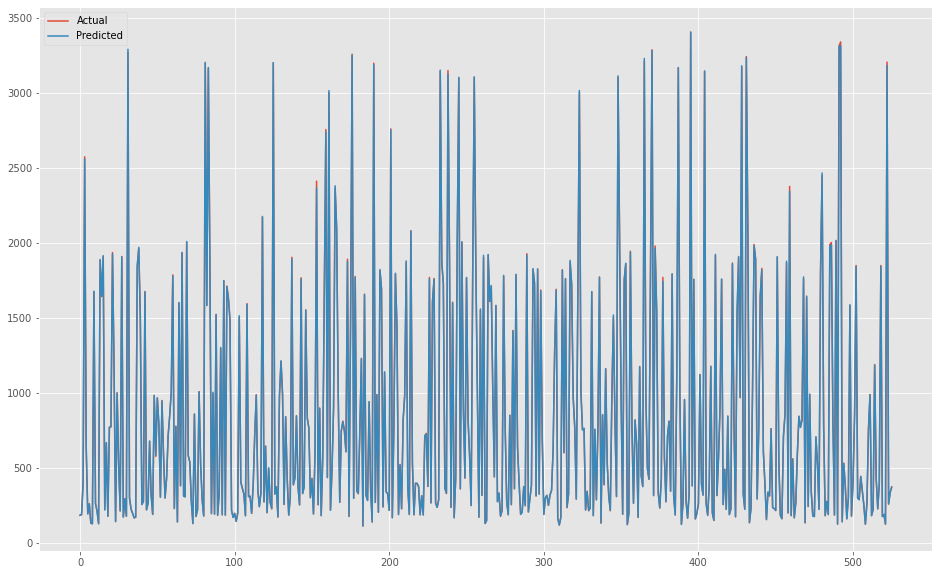

In [95]:
X_test = sm.tools.tools.add_constant(X_test, has_constant='add')
Y_test_p = model.predict(X_test)
plt.figure(figsize=(16,10))
plt.plot(range(0,len(Y_test)),Y_test, label='Actual')
plt.plot(range(0,len(Y_test)),Y_test_p, label='Predicted')
plt.legend(loc='upper left')

In [101]:
r2_linear = r2_score(Y_test, Y_test_p)
mse_linear=mean_squared_error(Y_test, Y_test_p)
mae_linear=mean_absolute_error(Y_test, Y_test_p)
rmse_linear = np.sqrt(mse_linear)

In [103]:
print('The R2_Score of the Linear Regression is {}'.format(r2_linear))
print('The MSE of the Linear Regression is {}'.format(mse_linear))
print('The MAE of the Linear Regression is {}'.format(mae_linear))
print('The RMSE of the Linear Regression is {}'.format(rmse_linear))

The R2_Score of the Linear Regression is 0.999952267002915
The MSE of the Linear Regression is 30.77830568055066
The MAE of the Linear Regression is 2.923977114735201
The RMSE of the Linear Regression is 5.547819903399051


###Decision Tree

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=42, test_size=0.2)

In [108]:
#Decision Tree classifier 
dtr = DecisionTreeRegressor(max_depth = 5, min_samples_split=5)
dtr.fit(X_train,Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [109]:
Y_pred = dtr.predict(X_test)

In [110]:
r2_dt = r2_score(Y_test, Y_pred)
mse_dt = mean_squared_error(Y_test, Y_pred)
mae_dt = mean_absolute_error(Y_test, Y_pred)
rmse_dt = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [112]:
print('The R2_Score for Decision Tree with max_depth 5 is {}'.format(r2_dt))
print('The MSE for Decision Tree with max_depth 5 is {}'.format(mse_dt))
print('The MAE for Decision Tree with max_depth 5 is {}'.format(mae_dt))
print('The RMSE for Decision Tree with max_depth 5 is {}'.format(rmse_dt))

The R2_Score for Decision Tree with max_depth 5 is 0.9988789949813942
The MSE for Decision Tree with max_depth 5 is 722.8256602161692
The MAE for Decision Tree with max_depth 5 is 18.830409085481413
The RMSE for Decision Tree with max_depth 5 is 26.88541724087929


In [113]:
dtr = DecisionTreeRegressor(max_depth = 7 , min_samples_split=5)
dtr.fit(X_train,Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [114]:
Y_pred = dtr.predict(X_test)

In [115]:
r2_dt = r2_score(Y_test, Y_pred)
mse_dt = mean_squared_error(Y_test, Y_pred)
mae_dt = mean_absolute_error(Y_test, Y_pred)
rmse_dt = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [116]:
print('The R2_Score for Decision Tree with max_depth 7 is {}'.format(r2_dt))
print('The MSE for Decision Tree with max_depth 7 is {}'.format(mse_dt))
print('The MAE for Decision Tree with max_depth 7 is {}'.format(mae_dt))
print('The RMSE for Decision Tree with max_depth 7 is {}'.format(rmse_dt))

The R2_Score for Decision Tree with max_depth 7 is 0.9996886024360782
The MSE for Decision Tree with max_depth 7 is 200.78960039937354
The MAE for Decision Tree with max_depth 7 is 8.019201667328652
The RMSE for Decision Tree with max_depth 7 is 14.17002471414124


In [117]:
def train_and_plot_tree(X_train, Y_train, X_test, Y_test, max_depth = 5):
    dtr = DecisionTreeRegressor(max_depth = max_depth)
    dtr.fit(X_train,Y_train)
    Y_train_pred = dtr.predict(X_train)
    r2 = r2_score(Y_train, Y_train_pred)
    Y_test_pred = dtr.predict(X_test)
    r2_test = r2_score(Y_test, Y_test_pred)
    features = list(X.columns)
    plt.figure(figsize=[20,14])
    tree.plot_tree(dtr, feature_names=features, filled=True)
    plt.show()

R Squared on train data:  0.9991148918229994
R Squared on test data:  0.9988787902036794


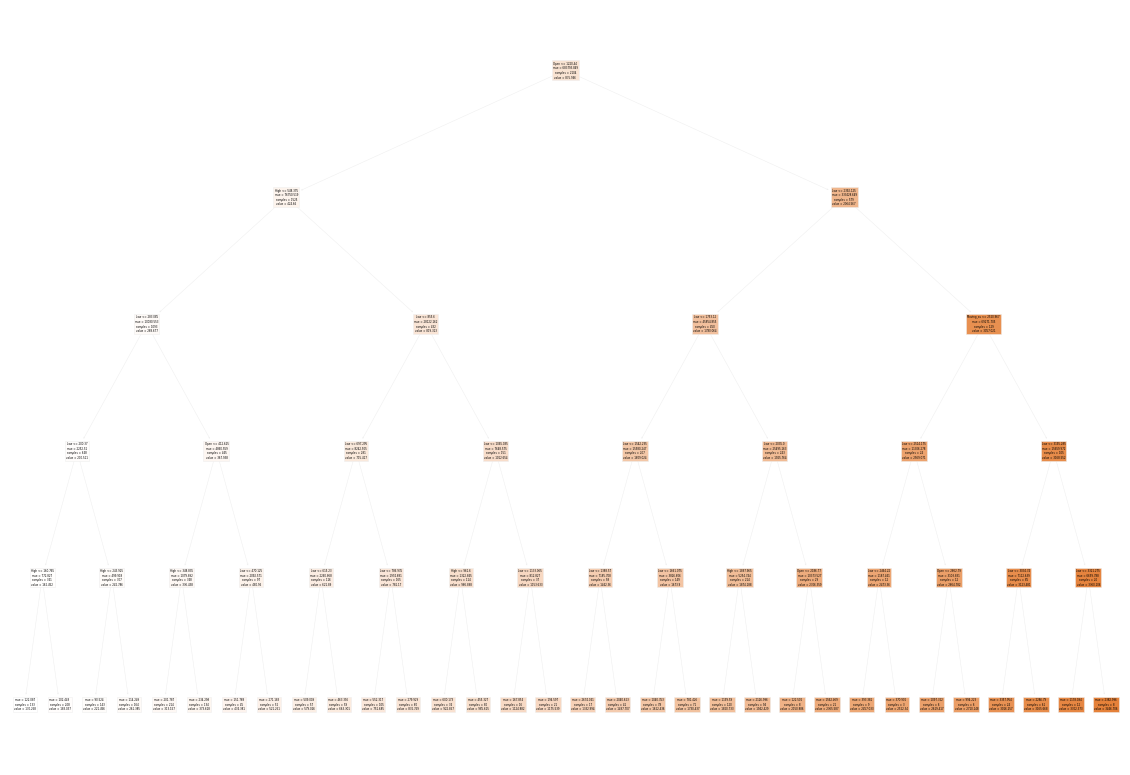

In [118]:
# Decision Tree iMAGE when max_depth=5
train_and_plot_tree(X_train, Y_train, X_test, Y_test, max_depth = 5)

R Squared on train data:  0.9871900270943077
R Squared on test data:  0.9880752111098237


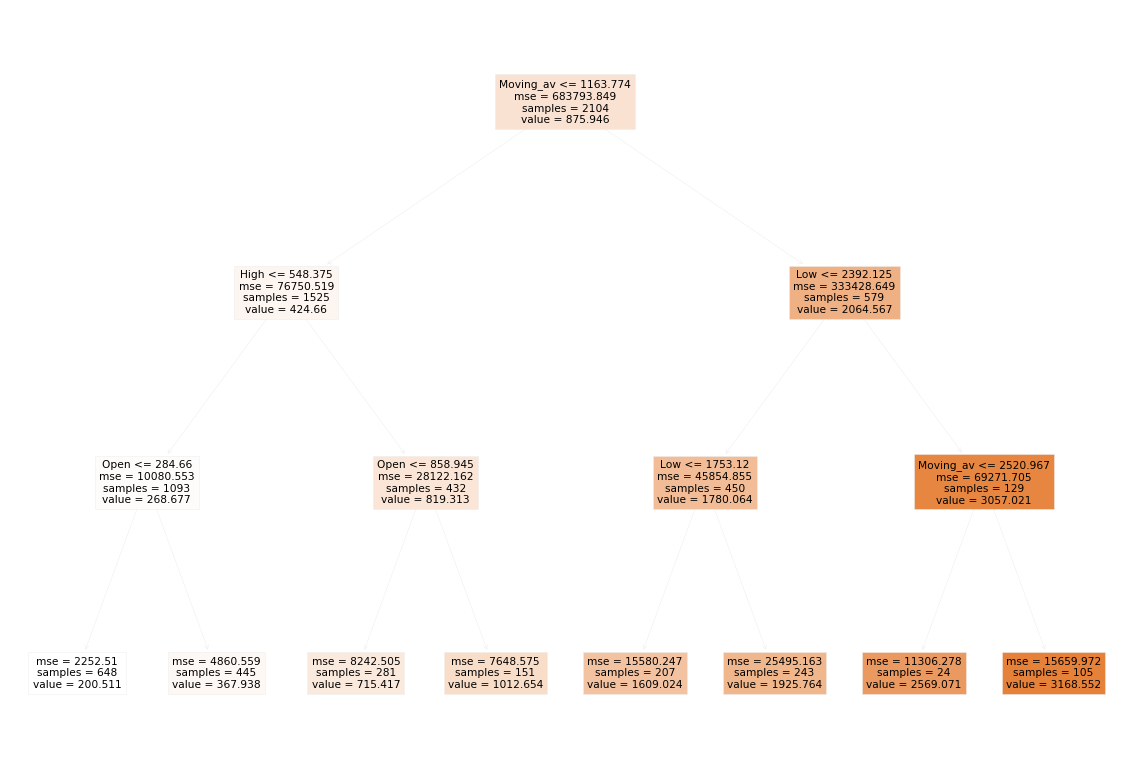

In [119]:
#Decision Tree image with max_depth =3
train_and_plot_tree(X_train, Y_train, X_test, Y_test, max_depth = 3)

#Random forest

In [120]:
#Random forest classifier
rfr = RandomForestRegressor(random_state=100 ,oob_score=True, max_features='sqrt')
rfr.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=100, verbose=0, warm_start=False)

In [121]:
#predicting values with the X_test
Y_pred_rf = rfr.predict(X_test)

In [122]:
#calculating evaluation metrics
r2_rf = r2_score(Y_test, Y_pred_rf)
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
rmse_rf = np.sqrt((mean_squared_error(Y_test, Y_pred_rf)))

In [123]:
#printing the values
print('The R2_Score for Random Forest is {}'.format(r2_rf))
print('The MSE for Random Forest is {}'.format(mse_rf))
print('The MAE for Random Forest is {}'.format(mae_rf))
print('The RMSE forRandom Forest is {}'.format(rmse_rf))

The R2_Score for Random Forest is 0.999822601748333
The MSE for Random Forest is 114.38664970639019
The MAE for Random Forest is 5.257770796801202
The RMSE forRandom Forest is 10.69516945664678


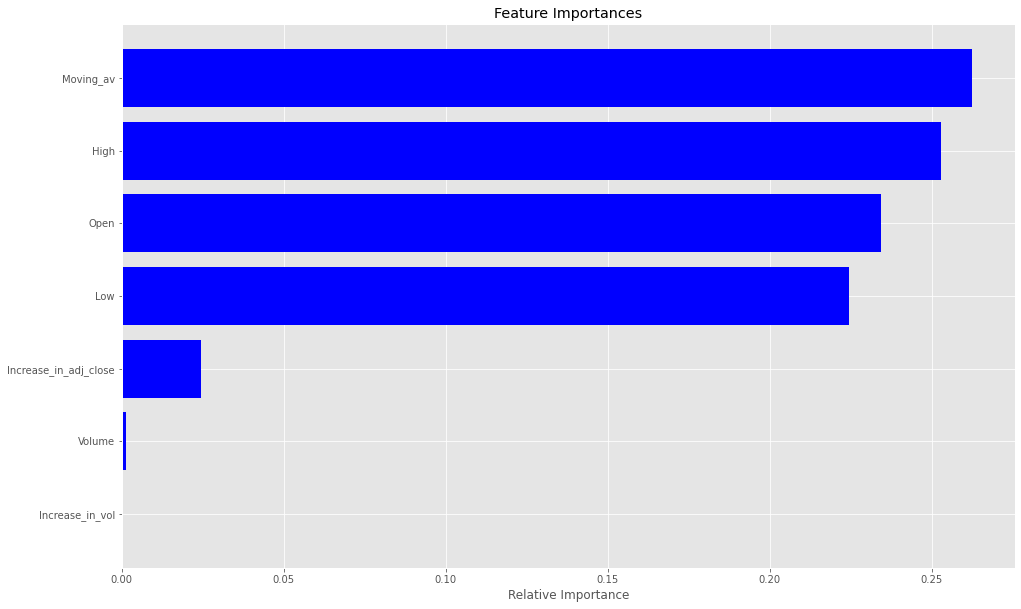

In [124]:
#ploting the important features in the dataset
features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(16,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost Model

In [125]:
xgr = XGBRegressor()

In [126]:
xgr.fit(X_train, Y_train)
Y_pred_xgb = xgr.predict(X_test)

[01:18:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [128]:
##calculating evaluation metrics

r2_xgb = r2_score(Y_test, Y_pred_xgb)
mse_xgb = mean_squared_error(Y_test, Y_pred_xgb)
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
rmse_xgb = np.sqrt((mean_squared_error(Y_test, Y_pred_xgb)))

In [129]:
print('The R2_Score for XGBOOST is {}'.format(r2_xgb))
print('The MSE for XGBOOST is {}'.format(mse_xgb))
print('The MAE for XGBOOST is {}'.format(mae_xgb))
print('The RMSE for XGBOOST is {}'.format(rmse_xgb))

The R2_Score for XGBOOST is 0.9998341363487833
The MSE for XGBOOST is 106.9491226236613
The MAE for XGBOOST is 5.936697608164508
The RMSE for XGBOOST is 10.341620889573418


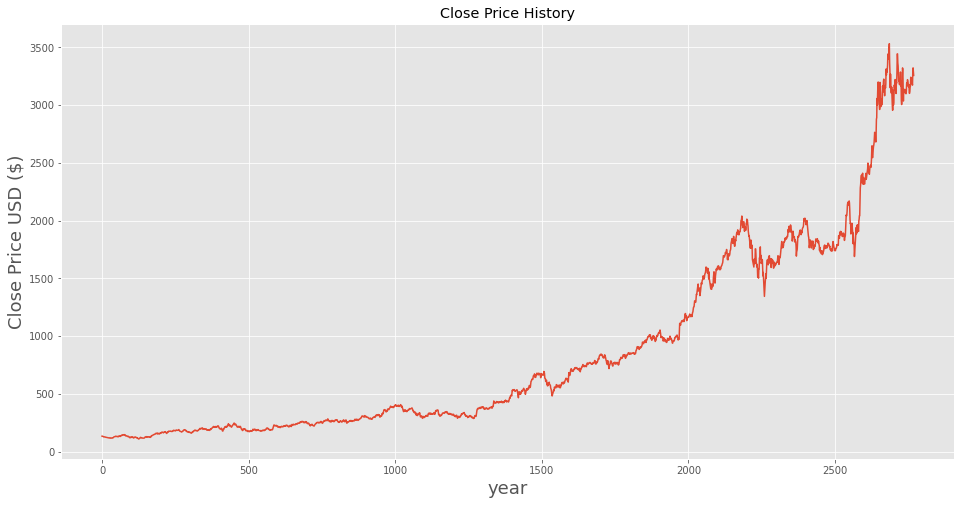

In [131]:
#ploting the close column
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(AMZN_df['close'])
plt.xlabel('year', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

##LSVM

In [132]:
# Create a new dataframe with only the 'Close column 
data = AMZN_df.filter(['close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2499

In [133]:
#scaling the data using minmax scaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00723488],
       [0.00746572],
       [0.00675275],
       ...,
       [0.93879866],
       [0.92823565],
       [0.91978517]])

In [134]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00723488, 0.00746572, 0.00675275, 0.00618588, 0.00532097,
       0.00539694, 0.00486221, 0.00259766, 0.00240189, 0.00319959,
       0.00307395, 0.00245156, 0.00209508, 0.00244864, 0.00259182,
       0.00236682, 0.00309148, 0.00270578, 0.00489436, 0.00566576,
       0.0057768 , 0.00612744, 0.0057505 , 0.00624432, 0.00714138,
       0.00662711, 0.00642549, 0.00661834, 0.00648685, 0.00690177,
       0.00619757, 0.00623263, 0.00587907, 0.00552258, 0.00757383,
       0.00759136, 0.00801798, 0.0077813 , 0.00662418, 0.00653068,
       0.00771993, 0.00751831, 0.00903483, 0.00936794, 0.00906405,
       0.01026792, 0.01071791, 0.00965138, 0.00972735, 0.01024454,
       0.01089615, 0.01109485, 0.00960755, 0.00882737, 0.00952281,
       0.00816992, 0.00828388, 0.00647223, 0.00622971, 0.00722611])]
[0.00652483326924435]

[array([0.00723488, 0.00746572, 0.00675275, 0.00618588, 0.00532097,
       0.00539694, 0.00486221, 0.00259766, 0.00240189, 0.00319959,
       0.00307395, 0.00245156, 0.00

In [135]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=100)

Epoch 1/100
2439/2439 [==============================] - 78s 31ms/step - loss: 0.0012
Epoch 2/100
2439/2439 [==============================] - 75s 31ms/step - loss: 3.1752e-04
Epoch 3/100
2439/2439 [==============================] - 75s 31ms/step - loss: 3.4557e-04
Epoch 4/100
2439/2439 [==============================] - 74s 30ms/step - loss: 1.6363e-04
Epoch 5/100
2439/2439 [==============================] - 75s 31ms/step - loss: 1.5562e-04
Epoch 6/100
2439/2439 [==============================] - 75s 31ms/step - loss: 1.5093e-04
Epoch 7/100
2439/2439 [==============================] - 75s 31ms/step - loss: 1.3394e-04
Epoch 8/100
2439/2439 [==============================] - 75s 31ms/step - loss: 1.4984e-04
Epoch 9/100
2439/2439 [==============================] - 75s 31ms/step - loss: 9.0619e-05
Epoch 10/100
2439/2439 [==============================] - 75s 31ms/step - loss: 9.8194e-05
Epoch 11/100
2439/2439 [==============================] - 75s 31ms/step - loss: 8.2018e-05
Epoch 12/100

In [136]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

76.22683919163592

In [138]:
r2_lstm = r2_score(y_test, predictions)
mse_lstm = mean_squared_error(y_test, predictions)
mae_lstm = mean_absolute_error(y_test, predictions)
rmse_lstm = np.sqrt((mean_squared_error(y_test, predictions)))

print('The R2_Score of the LSTM is {}'.format(r2_lstm))
print('The MSE of the LSTM is {}'.format(mse_lstm))
print('The MAE of the LSTM is {}'.format(mae_lstm))
print('The RMSE of the LSTM is {}'.format(rmse_lstm) )

The R2_Score of the LSTM is 0.694205560237344
The MSE of the LSTM is 5810.531013147522
The MAE of the LSTM is 58.81317464813932
The RMSE of the LSTM is 76.22683919163592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


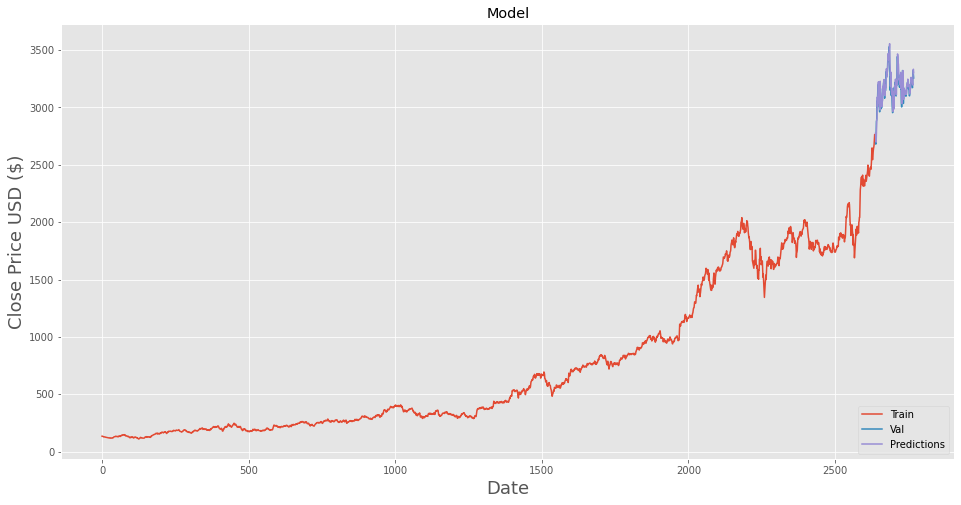

In [139]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [140]:
valid

,close,Predictions
2638,2692.870117,2775.429688
2639,2680.379883,2705.555664
2640,2758.820068,2698.126709
2641,2878.699951,2775.365967
2642,2890.300049,2894.656006
...,...,...
2764,3172.689941,3206.829346
2765,3283.959961,3195.835693
2766,3322.000000,3311.646973
2767,3285.850098,3333.732422
